In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# 폰트 설정
from matplotlib import font_manager, rc

# 폰트 설정
font_path = '/content/NanumGothic-Regular.ttf'
font_manager.fontManager.addfont(font_path)
font = font_manager.FontProperties(fname=font_path, size=10).get_name()
plt.rc('font', family=font)
plt.rcParams['axes.unicode_minus'] = False

def process_data(file_name, column_name):
    df = pd.read_excel(file_name)
    df = df.T
    df.columns = [column_name]
    df.index = df.index.astype(int)

    df[column_name] = df[column_name].astype(str).str.replace(',', '').astype(float)
    return df.sort_index()

gdp = process_data('GDP.xlsx', 'GDP')
youth_unemployment = process_data('청년실업률.xlsx', '청년실업률')
youth_population = process_data('청년인구.xlsx', '청년인구')
min_wage = process_data('최저임금.xlsx', '최저임금')

combined_df = pd.concat([youth_unemployment, gdp, youth_population, min_wage], axis=1)
print(combined_df.head())

      청년실업률       GDP     청년인구    최저임금
2000    8.1  675732.6  13305.0  1600.0
2001    7.9  732723.1  13316.0  1865.0
2002    7.0  813225.4  13272.0  2100.0
2003    8.0  868110.6  13173.0  2275.0
2004    8.2  942885.3  12929.0  2510.0


    교육정도별   2000 2000.1 2000.2 2000.3 2000.4 2000.5 2000.6 2000.7   2001  ...  \
1      고졸  15194   9840   9336    504   5354   64.8    5.1   61.4  15503  ...   
3    전문대졸   2170   1685   1578    107    485   77.7    6.4   72.7   2353  ...   
4  대학교졸이상   4846   3743   3620    123   1104   77.2    3.3   74.7   5049  ...   

  2022.6 2022.7   2023 2023.1 2023.2 2023.3 2023.4 2023.5 2023.6 2023.7  
1    3.1   62.1  16852  10829  10530    299   6022   64.3    2.8   62.5  
3    3.2     76   5142   4061   3941    119   1081     79    2.9   76.7  
4    2.4   76.5  13597  10679  10420    259   2918   78.5    2.4   76.6  

[3 rows x 193 columns]


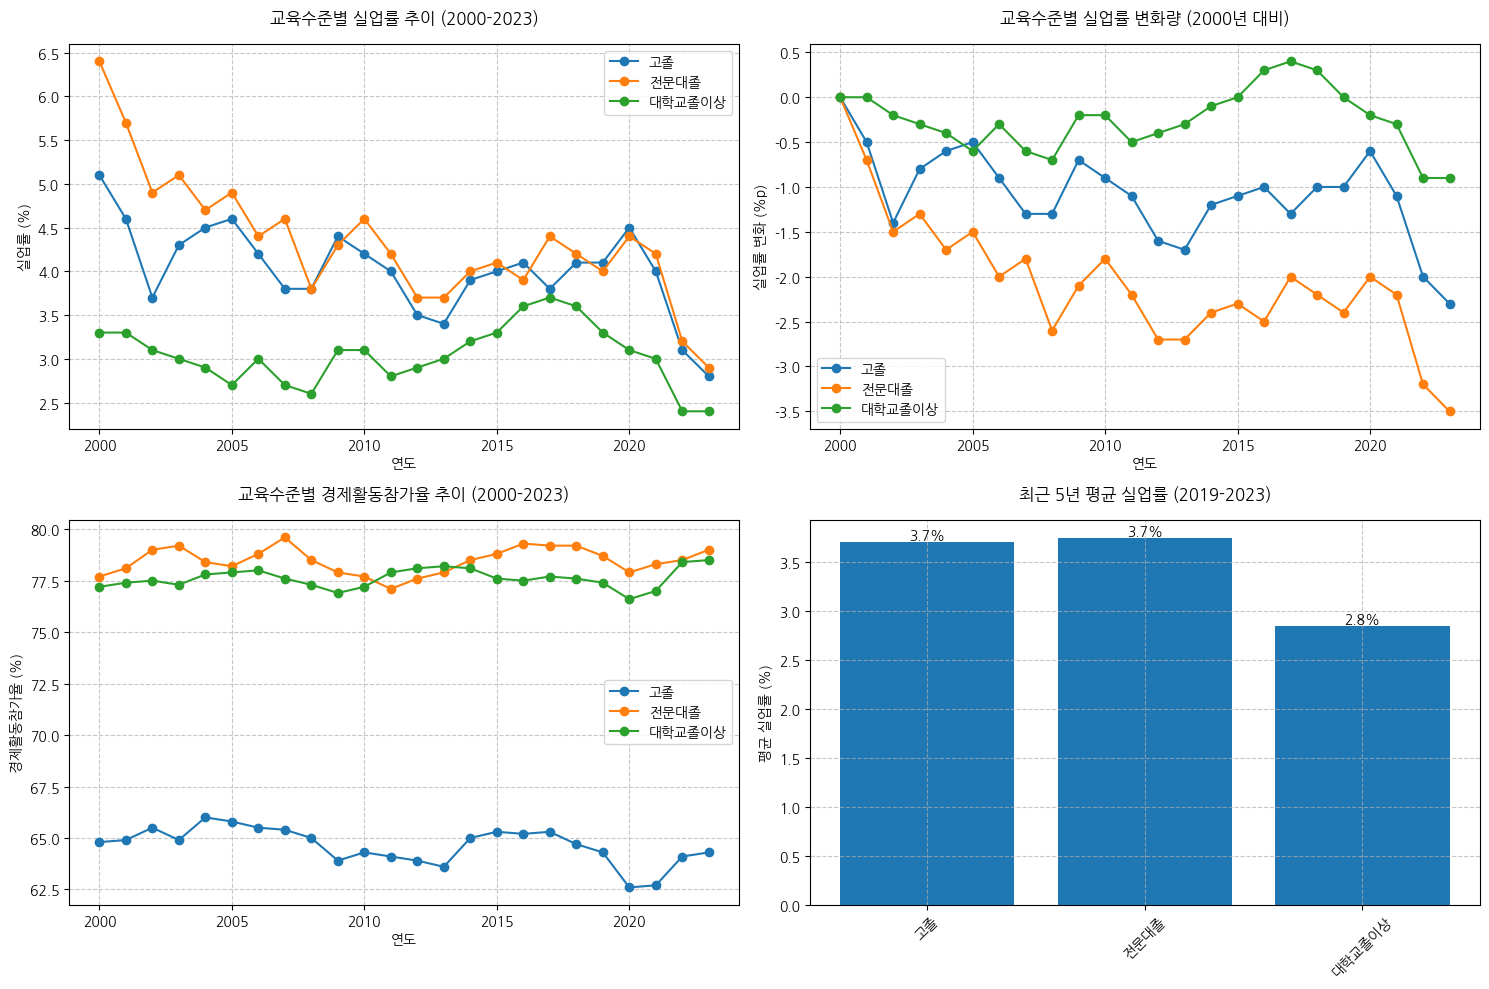


=== 교육수준별 실업률 기초 통계 ===
교육정도별         고졸       전문대졸     대학교졸이상
count  24.000000  24.000000  24.000000
mean    4.020833   4.345833   3.045833
std     0.504742   0.740141   0.343864
min     2.800000   2.900000   2.400000
25%     3.800000   3.975000   2.875000
50%     4.050000   4.250000   3.050000
75%     4.325000   4.625000   3.300000
max     5.100000   6.400000   3.700000

=== 교육수준 간 실업률 상관관계 ===
교육정도별         고졸      전문대졸    대학교졸이상
교육정도별                               
고졸      1.000000  0.835289  0.445167
전문대졸    0.835289  1.000000  0.363802
대학교졸이상  0.445167  0.363802  1.000000

=== 최근 5년(2019-2023) 평균 실업률 ===
교육정도별
고졸        3.70
전문대졸      3.74
대학교졸이상    2.84
dtype: float64


In [3]:
df = pd.read_csv('경제활동인구.csv', encoding='cp949')

# 필요한 교육수준만 선택
df_filtered = df[df['교육정도별'].isin(['고졸', '전문대졸', '대학교졸이상'])]
print(df_filtered)
# 실업률과 경제활동참가율 데이터 추출
# 각 행에서 실업률과 경제활동참가율이 있는 열의 위치를 찾아서 데이터 추출
years = range(2000, 2024)
unemployment_data = []
participation_data = []

for _, row in df_filtered.iterrows():
    # 실업률과 경제활동참가율 데이터 추출
    unemployment = [float(row[str(year) + '.6']) for year in years]
    participation = [float(row[str(year) + '.5']) for year in years]
    unemployment_data.append(unemployment)
    participation_data.append(participation)

# DataFrame으로 변환
unemployment_df = pd.DataFrame(unemployment_data,
                             index=df_filtered['교육정도별'],
                             columns=years)
participation_df = pd.DataFrame(participation_data,
                              index=df_filtered['교육정도별'],
                              columns=years)

# 시각화
plt.figure(figsize=(15, 10))

# 1. 실업률 추이
plt.subplot(2, 2, 1)
for edu in df_filtered['교육정도별']:
    plt.plot(years, unemployment_df.loc[edu], marker='o', label=edu)
plt.title('교육수준별 실업률 추이 (2000-2023)', fontsize=12, pad=15)
plt.xlabel('연도')
plt.ylabel('실업률 (%)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# 2. 실업률 변화량 (2000년 대비)
plt.subplot(2, 2, 2)
for edu in df_filtered['교육정도별']:
    change = unemployment_df.loc[edu] - unemployment_df.loc[edu][2000]
    plt.plot(years, change, marker='o', label=edu)
plt.title('교육수준별 실업률 변화량 (2000년 대비)', fontsize=12, pad=15)
plt.xlabel('연도')
plt.ylabel('실업률 변화 (%p)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# 3. 경제활동참가율 추이
plt.subplot(2, 2, 3)
for edu in df_filtered['교육정도별']:
    plt.plot(years, participation_df.loc[edu], marker='o', label=edu)
plt.title('교육수준별 경제활동참가율 추이 (2000-2023)', fontsize=12, pad=15)
plt.xlabel('연도')
plt.ylabel('경제활동참가율 (%)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

# 4. 최근 5년 평균 실업률 (2019-2023)
plt.subplot(2, 2, 4)
recent_years = list(range(2019, 2024))
recent_means = unemployment_df[recent_years].mean(axis=1)
bars = plt.bar(df_filtered['교육정도별'], recent_means)
plt.title('최근 5년 평균 실업률 (2019-2023)', fontsize=12, pad=15)
plt.ylabel('평균 실업률 (%)')

# 막대 위에 값 표시
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}%',
             ha='center', va='bottom')

plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# 기초 통계 분석
print("\n=== 교육수준별 실업률 기초 통계 ===")
print(unemployment_df.T.describe())

# 상관관계 분석
print("\n=== 교육수준 간 실업률 상관관계 ===")
print(unemployment_df.T.corr())

# 최근 5년 평균값 출력
print("\n=== 최근 5년(2019-2023) 평균 실업률 ===")
print(recent_means)


=== 청년실업률 예측 결과 (2024-2028) ===
2024년: -0.2% (95% 신뢰구간: -0.9% ~ 0.6%)
2025년: 4.0% (95% 신뢰구간: 3.0% ~ 5.1%)
2026년: 8.3% (95% 신뢰구간: 7.2% ~ 9.4%)
2027년: 12.8% (95% 신뢰구간: 11.6% ~ 14.0%)
2028년: 17.2% (95% 신뢰구간: 16.0% ~ 18.4%)


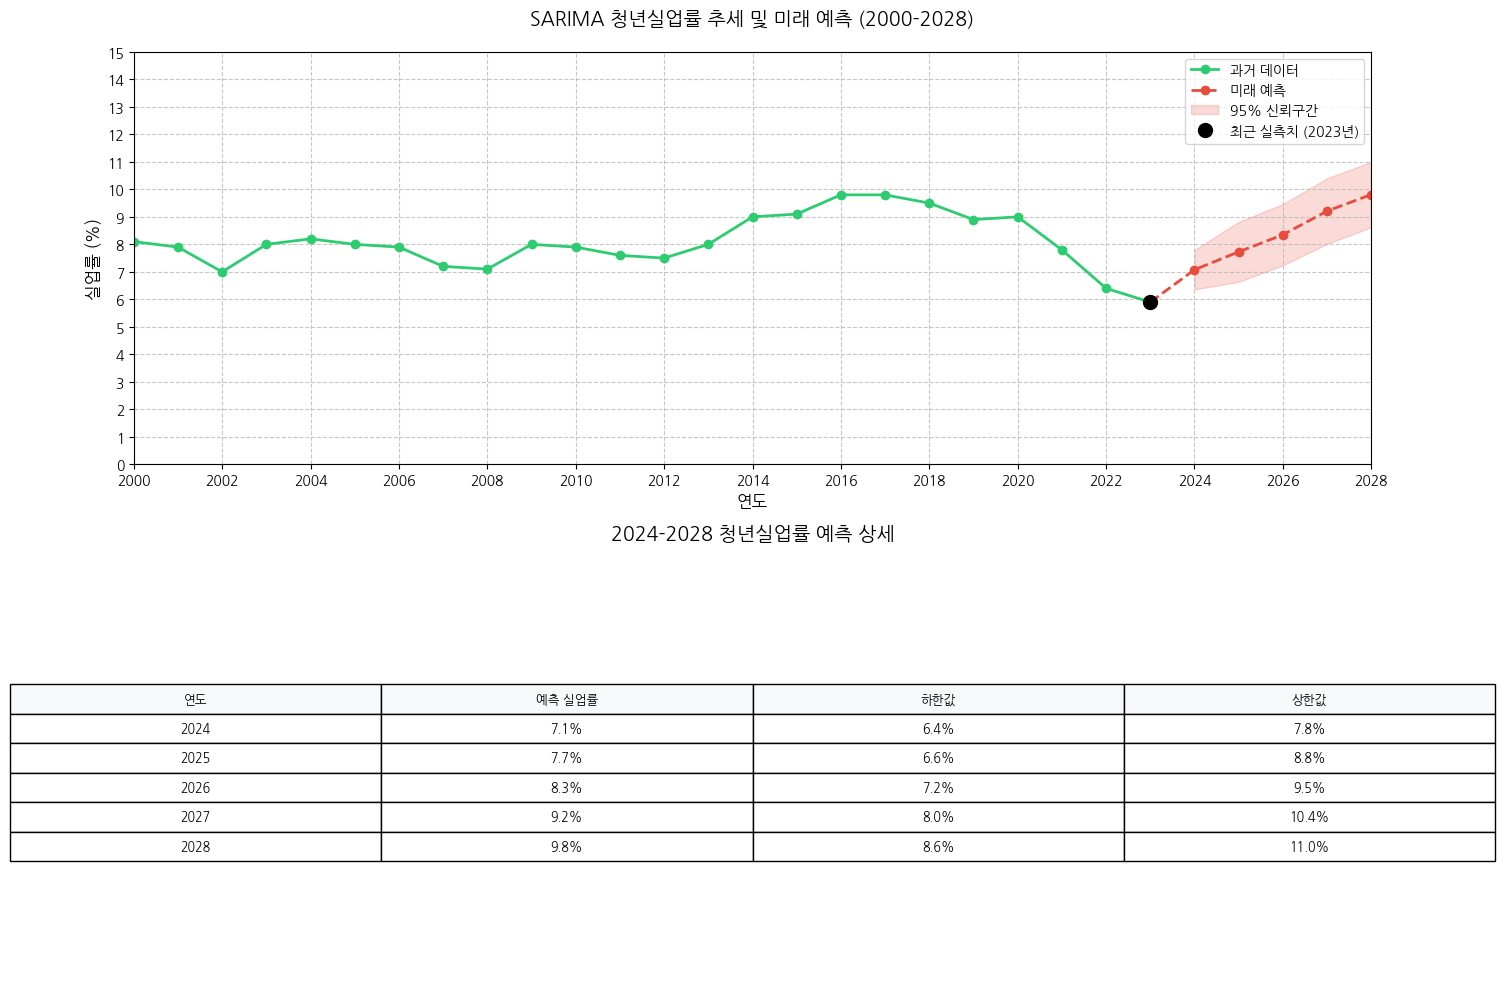


=== 청년실업률 예측 결과 (2024-2028) ===
2024년: 7.1% (95% 신뢰구간: 6.4% ~ 7.8%)
2025년: 7.7% (95% 신뢰구간: 6.6% ~ 8.8%)
2026년: 8.3% (95% 신뢰구간: 7.2% ~ 9.5%)
2027년: 9.2% (95% 신뢰구간: 8.0% ~ 10.4%)
2028년: 9.8% (95% 신뢰구간: 8.6% ~ 11.0%)


In [11]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
font_path = '/content/NanumGothic-Regular.ttf'
font_manager.fontManager.addfont(font_path)
font = font_manager.FontProperties(fname=font_path, size=10).get_name()
plt.rc('font', family=font)
plt.rcParams['axes.unicode_minus'] = False

# 데이터 전처리 - 로그 변환 적용
scaler = StandardScaler()
exog_df = pd.DataFrame({
    'GDP': scaler.fit_transform(np.log1p(combined_df[['GDP']])).flatten(),
    '청년인구': scaler.fit_transform(combined_df[['청년인구']]).flatten(),
    '최저임금': scaler.fit_transform(np.log1p(combined_df[['최저임금']])).flatten()
}, index=combined_df.index)

# 데이터 분할
n = len(combined_df)
train_size = int(n * 0.8)
train_data = combined_df['청년실업률'][:train_size]
test_data = combined_df['청년실업률'][train_size:]
train_exog = exog_df[:train_size]
test_exog = exog_df[train_size:]

last_year = combined_df.index[-1]
future_periods = 5

# SARIMAX 모델 정의 및 학습 - 파라미터 수정
model = SARIMAX(train_data,
               exog=train_exog,
               order=(2, 1, 2),          # ARIMA 파라미터 수정
               seasonal_order=(1, 0, 1, 4),  # 계절성 파라미터 수정
               enforce_stationarity=True)
model_fit = model.fit(disp=False)

# 테스트 데이터 예측
forecast = model_fit.get_prediction(start=train_size,
                                  end=n-1,
                                  exog=test_exog)
forecast_mean = forecast.predicted_mean

# 미래 외생변수 생성 수정
future_exog = pd.DataFrame(index=range(last_year + 1, last_year + future_periods + 1))
for col in ['GDP', '청년인구', '최저임금']:
    growth_rate = (recent_vals.pct_change() + 1).mean()

    last_val = combined_df[col].iloc[-1]
    future_vals = []
    for _ in range(future_periods):
        last_val = last_val * growth_rate
        future_vals.append(last_val)

    # 로그 변환 적용 (GDP와 최저임금)
    if col in ['GDP', '최저임금']:
        scaled_values = scaler.fit_transform(np.log1p(np.array(future_vals).reshape(-1, 1))).flatten()
    else:
        scaled_values = scaler.fit_transform(np.array(future_vals).reshape(-1, 1)).flatten()

    future_exog[col] = scaled_values

# 미래 예측 수행
future_forecast = model_fit.get_forecast(steps=future_periods, exog=future_exog)
future_mean = future_forecast.predicted_mean
future_conf = future_forecast.conf_int()

# 예측 결과 출력
print("\n=== 청년실업률 예측 결과 (2024-2028) ===")
for year, (pred, (lower, upper)) in zip(range(2024, 2029), zip(future_mean, future_conf.values)):
    print(f"{year}년: {pred:.1f}% (95% 신뢰구간: {lower:.1f}% ~ {upper:.1f}%)")

scaler = StandardScaler()
exog_df = pd.DataFrame({
    'GDP': scaler.fit_transform(np.log1p(combined_df[['GDP']])).flatten(),
    '청년인구': scaler.fit_transform(combined_df[['청년인구']]).flatten(),
    '최저임금': scaler.fit_transform(np.log1p(combined_df[['최저임금']])).flatten()
}, index=combined_df.index)

# 데이터 분할
n = len(combined_df)
train_size = int(n * 0.8)
train_data = combined_df['청년실업률'][:train_size]
test_data = combined_df['청년실업률'][train_size:]
train_exog = exog_df[:train_size]
test_exog = exog_df[train_size:]

# SARIMAX 모델 정의 및 학습 - 파라미터 수정
model = SARIMAX(train_data,
               exog=train_exog,
               order=(2, 1, 2),          # ARIMA 파라미터 수정
               seasonal_order=(1, 0, 1, 4),  # 계절성 파라미터 수정
               enforce_stationarity=True)
model_fit = model.fit(disp=False)

# 테스트 데이터 예측
forecast = model_fit.get_prediction(start=train_size,
                                  end=n-1,
                                  exog=test_exog)
forecast_mean = forecast.predicted_mean

# 미래 외생변수 생성 수정
future_exog = pd.DataFrame(index=range(last_year + 1, last_year + future_periods + 1))
for col in ['GDP', '청년인구', '최저임금']:
    # 전체 기간의 평균 변화율 사용
    growth_rate = (combined_df[col].pct_change() + 1).mean()  # tail(3) 제거

    last_val = combined_df[col].iloc[-1]
    future_vals = []
    for _ in range(future_periods):
        last_val = last_val * growth_rate
        future_vals.append(last_val)

    # 로그 변환 적용 (GDP와 최저임금)
    if col in ['GDP', '최저임금']:
        scaled_values = scaler.fit_transform(np.log1p(np.array(future_vals).reshape(-1, 1))).flatten()
    else:
        scaled_values = scaler.fit_transform(np.array(future_vals).reshape(-1, 1)).flatten()

    future_exog[col] = scaled_values

# 미래 예측 수행
future_forecast = model_fit.get_forecast(steps=future_periods, exog=future_exog)
future_mean = future_forecast.predicted_mean
future_conf = future_forecast.conf_int()

# 종합 시각화
plt.figure(figsize=(15, 10))

# 1. 실제 데이터와 미래 예측을 포함한 그래프
plt.subplot(2, 1, 1)

# 연도 범위 설정
x_ticks = range(2000, 2029, 2)

# 과거 데이터 플롯
plt.plot(combined_df.index, combined_df['청년실업률'],
         label='과거 데이터', color='#2ecc71',
         linewidth=2, marker='o')

# 미래 예측 데이터 플롯 (2023년부터 시작)
future_years = [2023] + list(range(2024, 2029))  # 2023년 포함
future_values = [combined_df['청년실업률'].iloc[-1]] + list(future_mean)  # 마지막 실제값 포함

plt.plot(future_years, future_values, marker='o',
         label='미래 예측', color='#e74c3c',
         linewidth=2, linestyle='dashed')

# 신뢰구간 표시
conf_years = range(2024, 2029)
plt.fill_between(conf_years,
                 future_conf.iloc[:,0],
                 future_conf.iloc[:,1],
                 color='#e74c3c', alpha=0.2,
                 label='95% 신뢰구간')

# 2023년(마지막 실측치) 강조
plt.plot(2023, combined_df['청년실업률'].iloc[-1], 'ko',
         markersize=10, label='최근 실측치 (2023년)')

plt.title('SARIMA 청년실업률 추세 및 미래 예측 (2000-2028)', fontsize=14, pad=20)
plt.xlabel('연도', fontsize=12)
plt.ylabel('실업률 (%)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=10, loc='upper right')

# 축 범위 및 눈금 설정
plt.xlim(2000, 2028)
plt.ylim(0, 15)
plt.xticks(x_ticks)
plt.yticks(range(0, 16, 1))

# 예측 결과 테이블
table_data = []
for year, (pred, (lower, upper)) in zip(range(2024, 2029), zip(future_mean, future_conf.values)):
    table_data.append([year, f"{pred:.1f}%", f"{lower:.1f}%", f"{upper:.1f}%"])

plt.subplot(2, 1, 2)
table = plt.table(cellText=table_data,
                 colLabels=['연도', '예측 실업률', '하한값', '상한값'],
                 loc='center',
                 cellLoc='center',
                 colColours=['#f8f9fa']*4)
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1.2, 1.5)

plt.axis('off')
plt.title('2024-2028 청년실업률 예측 상세', fontsize=14, pad=20)

plt.tight_layout()
plt.show()

# 예측 결과 출력
print("\n=== 청년실업률 예측 결과 (2024-2028) ===")
for year, (pred, (lower, upper)) in zip(range(2024, 2029), zip(future_mean, future_conf.values)):
    print(f"{year}년: {pred:.1f}% (95% 신뢰구간: {lower:.1f}% ~ {upper:.1f}%)")


고졸 - 최적 ARIMA 파라미터: (2, 1, 2)

=== 고졸 모델 성능 평가 ===
RMSE: 0.422
MAE: 0.362
MAPE: 10.578%

고졸 실업률 예측:
2024년: 3.08%
2025년: 3.50%
2026년: 3.79%
2027년: 3.57%
2028년: 3.13%

전문대졸 - 최적 ARIMA 파라미터: (2, 1, 3)

=== 전문대졸 모델 성능 평가 ===
RMSE: 0.559
MAE: 0.438
MAPE: 13.012%

전문대졸 실업률 예측:
2024년: 3.35%
2025년: 3.64%
2026년: 3.43%
2027년: 3.25%
2028년: 3.55%

대학교졸이상 - 최적 ARIMA 파라미터: (2, 0, 1)

=== 대학교졸이상 모델 성능 평가 ===
RMSE: 0.293
MAE: 0.207
MAPE: 7.842%

대학교졸이상 실업률 예측:
2024년: 2.36%
2025년: 2.44%
2026년: 2.61%
2027년: 2.83%
2028년: 3.05%


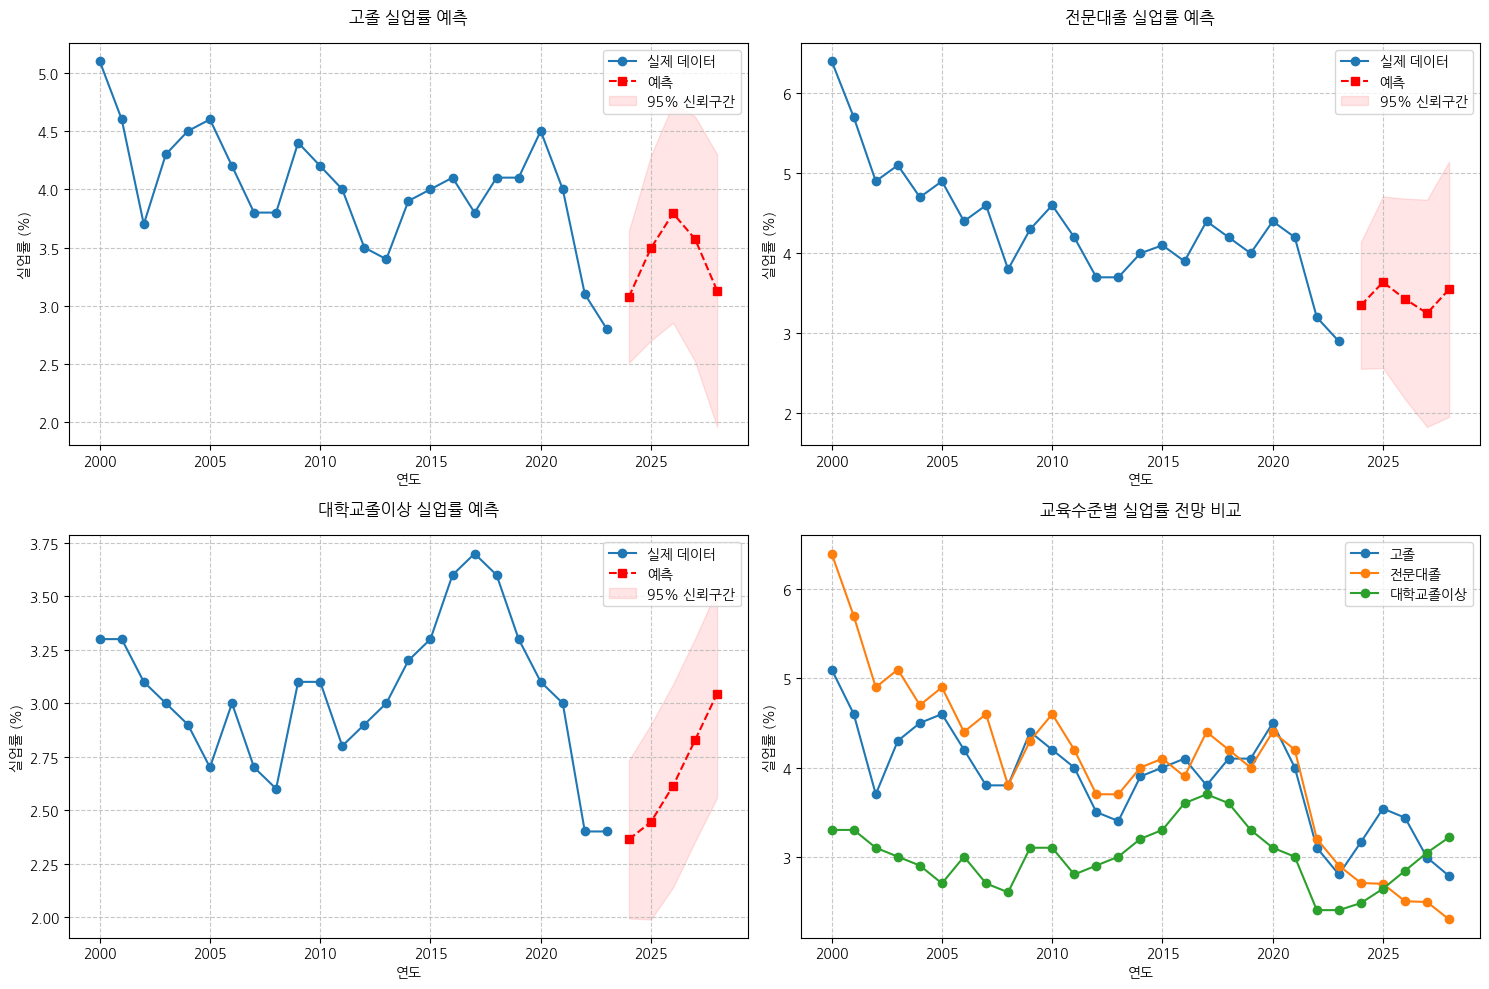

In [10]:

#########################################################################################################################
###############################                                ##########################################################
###############################  과거 데이터들로만 예측한 모델 ##########################################################
###############################                                ##########################################################
#########################################################################################################################
#########################################################################################################################

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
from itertools import product

# 데이터프레임 재구성
unemployment_df = unemployment_df.rename_axis(None)  # 인덱스 이름 제거
unemployment_df = unemployment_df.T  # 전치
years = pd.to_numeric(unemployment_df.index)  # 연도를 숫자로 변환
education_levels = unemployment_df.columns  # 교육 수준

def find_best_arima_params(data, max_p=2, max_d=1, max_q=2):
    """최적의 ARIMA 파라미터를 찾는 함수"""
    best_aic = float('inf')
    best_params = None
    best_model = None

    for p, d, q in product(range(max_p + 1), range(max_d + 1), range(max_q + 1)):
        if p == 0 and q == 0:  # (0,d,0) 모델 제외
            continue
        try:
            model = ARIMA(data, order=(p, d, q))
            results = model.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                best_params = (p, d, q)
                best_model = results
        except:
            continue

    if best_params is None:
        best_params = (1, 1, 1)  # 기본값 설정

    return best_params

def evaluate_forecast(actual, predicted):
    """예측 성능 평가 지표 계산"""
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mae = mean_absolute_error(actual, predicted)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100
    return rmse, mae, mape

# 데이터 준비
years = unemployment_df.index.astype(int)
education_levels = unemployment_df.columns

plt.figure(figsize=(15, 10))

for i, edu in enumerate(education_levels, 1):
   data = unemployment_df[edu]

   # 정상성 검정
   adf_result = adfuller(data)

   # ARIMA 파라미터 설정
   if edu == '전문대졸':
       order = (2, 1, 3)
   else:
       order = find_best_arima_params(data)

   print(f"\n{edu} - 최적 ARIMA 파라미터: {order}")

   # 모델 학습
   model = ARIMA(data, order=order)
   model_fit = model.fit()

   # 과거 데이터로 모델 성능 평가
   train_size = int(len(data) * 0.8)
   train_data = data[:train_size]
   test_data = data[train_size:]

   # 검증 기간 예측
   history = list(train_data)
   predictions = []

   for t in range(len(test_data)):
       model = ARIMA(history, order=order)
       model_fit = model.fit()
       output = model_fit.forecast()
       predictions.append(output[0])
       history.append(test_data.iloc[t])

   # 성능 평가
   rmse, mae, mape = evaluate_forecast(test_data, predictions)
   print(f"\n=== {edu} 모델 성능 평가 ===")
   print(f'RMSE: {rmse:.3f}')
   print(f'MAE: {mae:.3f}')
   print(f'MAPE: {mape:.3f}%')

   # 미래 5년 예측
   forecast_years = 5
   future_dates = range(max(years) + 1, max(years) + forecast_years + 1)
   forecast = model_fit.forecast(steps=forecast_years)

   print(f"\n{edu} 실업률 예측:")
   for year, rate in zip(future_dates, forecast):
    print(f"{year}년: {rate:.2f}%")
   # 신뢰구간 계산
   forecast_obj = model_fit.get_forecast(steps=forecast_years)
   conf_int = forecast_obj.conf_int()
   lower_bound = conf_int[:, 0]
   upper_bound = conf_int[:, 1]

   # 시각화
   plt.subplot(2, 2, i)
   plt.plot(years, data, label='실제 데이터', marker='o')
   plt.plot(future_dates, forecast, label='예측', marker='s', linestyle='--', color='red')
   plt.fill_between(future_dates,
                   lower_bound,
                   upper_bound,
                   color='red', alpha=0.1,
                   label='95% 신뢰구간')

   plt.title(f'{edu} 실업률 예측', fontsize=12, pad=15)
   plt.xlabel('연도')
   plt.ylabel('실업률 (%)')
   plt.grid(True, linestyle='--', alpha=0.7)
   plt.legend()

# 전체 교육수준 비교
plt.subplot(2, 2, 4)
for edu in education_levels:
   data = unemployment_df[edu]
   order = (2, 1, 2) if edu == '전문대졸' else find_best_arima_params(data)
   model = ARIMA(data, order=order)
   model_fit = model.fit()
   forecast = model_fit.forecast(steps=forecast_years)
   plt.plot(np.concatenate([years, future_dates]),
            np.concatenate([data, forecast]),
            label=edu, marker='o')

plt.title('교육수준별 실업률 전망 비교', fontsize=12, pad=15)
plt.xlabel('연도')
plt.ylabel('실업률 (%)')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()

plt.tight_layout()
plt.show()